In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
df = pd.read_csv("brazil_covid19_cities.csv")
df.head(2)

,date,state,name,code,cases,deaths
0,2020-03-28,Acre,Rio Branco,120040,25,0
1,2020-03-28,Alagoas,Maceió,270430,13,0


In [6]:
# Filtrando Paraiba
df_paraiba = df.loc[df.state == "Paraíba"]
df_paraiba.head(2)

,date,state,name,code,cases,deaths
115,2020-03-28,Paraíba,Campina Grande,250400,2,0
116,2020-03-28,Paraíba,Igaracy,250260,1,0


In [7]:
df_paraiba = df_paraiba.set_index('date')
df_paraiba.index = pd.to_datetime(df_paraiba.index, format='%Y-%m-%d')
df_paraiba = df_paraiba[['state','cases']].groupby('date').sum()
df_paraiba.head(2)

,cases
date,
2020-03-28,14
2020-03-29,14


In [8]:
df_paraiba.iloc[[0, -1]]

,cases
date,
2020-03-28,14
2020-05-14,2834


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

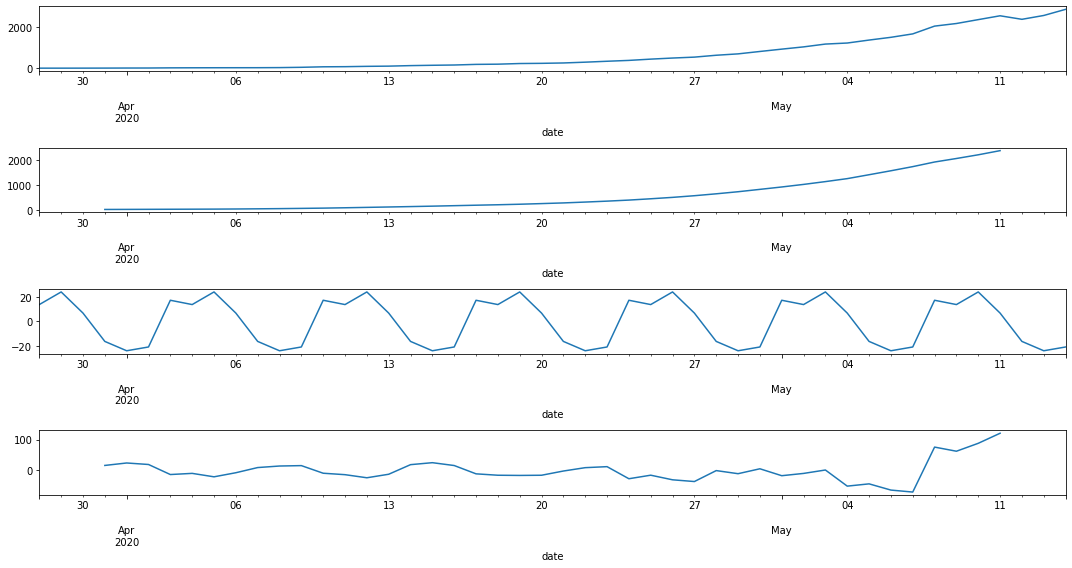

In [10]:
seasonplot = seasonal_decompose(df_paraiba)
# plotar a decomposicao
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1)
seasonplot.trend.plot(ax=ax2)
seasonplot.seasonal.plot(ax=ax3)
seasonplot.resid.plot(ax=ax4)
plt.tight_layout()

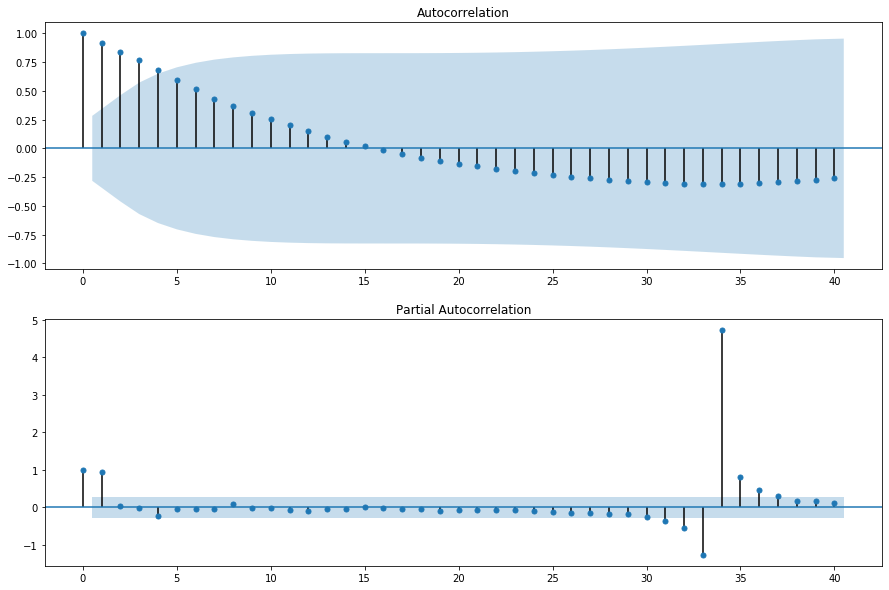

In [11]:
import statsmodels.api as sm
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
sm.graphics.tsa.plot_acf(df_paraiba.values.squeeze(), lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df_paraiba.values.squeeze(), lags=40, ax=ax2)
plt.show()

In [12]:
from pmdarima.arima import auto_arima
bruteforce_modelo = auto_arima(df_paraiba, start_p=0, start_d=0 ,start_q=0,max_p=8, max_d=8,max_q=8, m=7, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',suppress_warnings=True, stepwise=False)

Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=True]; AIC=460.897, BIC=464.274, Time=0.015 seconds
Fit ARIMA(0,1,0)x(0,1,1,7) [intercept=True]; AIC=462.519, BIC=467.585, Time=0.062 seconds
Fit ARIMA(0,1,0)x(0,1,2,7) [intercept=True]; AIC=463.838, BIC=470.593, Time=0.117 seconds
Fit ARIMA(0,1,0)x(1,1,0,7) [intercept=True]; AIC=462.744, BIC=467.811, Time=0.067 seconds
Fit ARIMA(0,1,0)x(1,1,1,7) [intercept=True]; AIC=463.981, BIC=470.737, Time=0.203 seconds
Fit ARIMA(0,1,0)x(1,1,2,7) [intercept=True]; AIC=465.837, BIC=474.282, Time=0.176 seconds
Fit ARIMA(0,1,0)x(2,1,0,7) [intercept=True]; AIC=464.086, BIC=470.841, Time=0.217 seconds
Fit ARIMA(0,1,0)x(2,1,1,7) [intercept=True]; AIC=465.925, BIC=474.369, Time=0.335 seconds
Fit ARIMA(0,1,0)x(2,1,2,7) [intercept=True]; AIC=467.798, BIC=477.931, Time=0.501 seconds
Fit ARIMA(0,1,1)x(0,1,0,7) [intercept=True]; AIC=462.207, BIC=467.274, Time=0.059 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=True]; AIC=462.919, BIC=469.674, Time=0.178 seconds
Fit ARIMA(

In [178]:
print(f"Resultado AIC: {bruteforce_modelo.aic()}")
print(f"Resultado melhores parametros (p,d,q): {bruteforce_modelo.order}")

Resultado AIC: 257.80952841403393
Resultado melhores parametros (p,d,q): (1, 2, 0)


In [14]:
futuro_forecast = bruteforce_modelo.predict(n_periods=30)

In [60]:
import datetime 
dataatual = datetime.datetime.today()
dataatual = datetime.datetime.today() - datetime.timedelta(days=1)
lista_datas = [dataatual + datetime.timedelta(days=x) for x in range(30)]
lista_datas = [pd.datetime.strftime(i,'%Y-%m-%d') for i in lista_datas]

In [65]:
futuro_forecast = bruteforce_modelo.predict(n_periods=30)
futuro_forecast = pd.DataFrame(futuro_forecast,index = lista_datas,columns=["cases"])
futuro_forecast.index.name = 'data'
futuro_forecast.index = pd.to_datetime(futuro_forecast.index)
futuro_forecast.cases = round(futuro_forecast.cases,0)
futuro_forecast.head(2)

,cases
data,
2020-05-15,3053.0
2020-05-16,3398.0


In [66]:
final = pd.concat([df_paraiba,futuro_forecast])
final.head(2)

,cases
2020-03-28,14.0
2020-03-29,14.0


In [78]:
import plotly.graph_objects as go   
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_paraiba.index, y=df_paraiba.cases,mode='lines+markers',
                    name='Atual'))

fig.add_trace(go.Scatter(x=futuro_forecast.index, y=futuro_forecast.cases,mode='lines+markers', name='Previsto',
line=dict(dash='dashdot')))

fig.update_layout(title="Previsão para os proximos 30 dias, casos acumulados COVID-19 Paraiba", width=1200, height=600)
fig.show()

In [154]:
dataatual = datetime.datetime.today()
dataatual = datetime.datetime.today() - datetime.timedelta(days=15)
lista_datas = [dataatual + datetime.timedelta(days=x) for x in range(15)]
lista_datas = [pd.datetime.strftime(i,'%Y-%m-%d') for i in lista_datas]

In [155]:
lista_datas

['2020-05-01',
 '2020-05-02',
 '2020-05-03',
 '2020-05-04',
 '2020-05-05',
 '2020-05-06',
 '2020-05-07',
 '2020-05-08',
 '2020-05-09',
 '2020-05-10',
 '2020-05-11',
 '2020-05-12',
 '2020-05-13',
 '2020-05-14',
 '2020-05-15']

In [160]:
df_validacao = df_paraiba.iloc[0:-14]

In [161]:
df_validacao.iloc[[0,-1]]

,cases
date,
2020-03-28,14
2020-04-30,814


In [181]:
from pmdarima.arima import auto_arima
valid_model = auto_arima(df_validacao, start_p=0, start_d=0 ,start_q=0,max_p=8, max_d=8,max_q=8, m=7, start_P=0, seasonal=False, trace=True, error_action='ignore',suppress_warnings=True, stepwise=False)

Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=273.135, BIC=276.067, Time=0.015 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=263.817, BIC=268.214, Time=0.064 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=261.131, BIC=266.994, Time=0.054 seconds
Fit ARIMA(0,2,3)x(0,0,0,0) [intercept=True]; AIC=260.664, BIC=267.992, Time=0.090 seconds
Fit ARIMA(0,2,4)x(0,0,0,0) [intercept=True]; AIC=259.253, BIC=268.048, Time=0.230 seconds
Fit ARIMA(0,2,5)x(0,0,0,0) [intercept=True]; AIC=259.243, BIC=269.503, Time=0.161 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=257.810, BIC=262.207, Time=0.018 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=259.659, BIC=265.522, Time=0.046 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=260.899, BIC=268.228, Time=0.071 seconds
Fit ARIMA(1,2,3)x(0,0,0,0) [intercept=True]; AIC=262.197, BIC=270.992, Time=0.093 seconds
Fit ARIMA(1,2,4)x(0,0,0,0) [intercept=True]; AIC=263.518, BIC=273.778, Time=0.174 seconds
Fit ARIMA(

In [182]:
print(f"Resultado AIC: {valid_model.aic()}")
print(f"Resultado melhores parametros (p,d,q): {valid_model.order}")

Resultado AIC: 257.80952841403393
Resultado melhores parametros (p,d,q): (1, 2, 0)


In [166]:
valid_forecast = valid_model.predict(n_periods=15)
valid_forecast = pd.DataFrame(valid_forecast,index = lista_datas,columns=["cases"])
valid_forecast.index.name = 'data'
valid_forecast.index = pd.to_datetime(valid_forecast.index)
valid_forecast.cases = round(valid_forecast.cases,0)
valid_forecast.head(2)

,cases
data,
2020-05-01,899.0
2020-05-02,1011.0


In [169]:
import plotly.graph_objects as go   
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_paraiba.index, y=df_paraiba.cases,mode='lines+markers',
                    name='Atual'))

fig.add_trace(go.Scatter(x=valid_forecast.index, y=valid_forecast.cases,mode='lines+markers', name='Validação 15 dias',
line=dict(dash='dashdot')))

fig.add_trace(go.Scatter(x=futuro_forecast.index, y=futuro_forecast.cases,mode='lines+markers', name='Previsto 30 dias',
line=dict(dash='dashdot')))

fig.update_layout(title="Validando eficiência do modelo com dados ja existentes.", width=1200, height=600)
fig.show()